In [1]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset

import pandas as pd
from sklearn.model_selection import train_test_split

from pathlib import Path
from PIL import Image

2024-03-27 04:19:15.551349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 04:19:15.551473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 04:19:15.685700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Creating Image, Caption Dictionary

In [4]:
images_captions_df = pd.DataFrame({'imgs': [],
                                    'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
         
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
images_captions_df.head()

,imgs,captions
0,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...
1,1_IM-0001-3001.dcm.png,The cardiac silhouette and mediastinum size ar...
2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
3,2_IM-0652-2001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
4,4_IM-2050-1001.dcm.png,There are diffuse bilateral interstitial and a...


# Set Encoder(ViT) Decoder(GPT2)

In [11]:
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p+ images_captions_df['imgs']
images_captions_df.head()


,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
2,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
3,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
4,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...


In [19]:
# maximum length for the captions
max_length = 512
sample = images_captions_df.iloc[99]

# sample image
image = Image.open(sample['imgs']).convert('RGB')
# sample caption
caption = sample['captions']

# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors='pt')
# apply tokenizer
outputs = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )

In [12]:
print(f"Inputs:\n{inputs}\nOutputs:\n{outputs}")

Inputs:
{'pixel_values': tensor([[[[-0.5059, -0.5059, -0.5059,  ..., -0.5059, -0.5059, -0.5059],
          [-0.5059, -0.5059, -0.5059,  ..., -0.4745, -0.4902, -0.4980],
          [-0.5059, -0.5059, -0.5059,  ..., -0.3725, -0.4118, -0.4275],
          ...,
          [-0.0824, -0.0667, -0.0275,  ..., -0.0588, -0.1137, -0.1529],
          [-0.0275, -0.0039,  0.0353,  ...,  0.0431, -0.0196, -0.0588],
          [ 0.0196,  0.0667,  0.0980,  ...,  0.1608,  0.0980,  0.0588]],

         [[-0.5059, -0.5059, -0.5059,  ..., -0.5059, -0.5059, -0.5059],
          [-0.5059, -0.5059, -0.5059,  ..., -0.4745, -0.4902, -0.4980],
          [-0.5059, -0.5059, -0.5059,  ..., -0.3725, -0.4118, -0.4275],
          ...,
          [-0.0824, -0.0667, -0.0275,  ..., -0.0588, -0.1137, -0.1529],
          [-0.0275, -0.0039,  0.0353,  ...,  0.0431, -0.0196, -0.0588],
          [ 0.0196,  0.0667,  0.0980,  ...,  0.1608,  0.0980,  0.0588]],

         [[-0.5059, -0.5059, -0.5059,  ..., -0.5059, -0.5059, -0.5059],
     

In [20]:
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = images_captions_df['imgs'].values
        self.captions = images_captions_df['captions'].values

    
    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # store the inputs and labels in the dict we created
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

# Split data

In [7]:
# train_df, test_df = train_test_split(images_captions_df, test_size=0.20, shuffle=True, random_state=42)

train_,test_df =train_test_split(images_captions_df, test_size=0.10, shuffle=True, random_state=42)

In [15]:
print(len(train_))
# print(len(val_df))
print(len(test_df))

5822
647


In [8]:
train_df,val_df =train_test_split(train_, test_size=0.10, shuffle=True, random_state=42)

In [17]:
print(len(train_df))
print(len(val_df))
print(len(test_df))


5239
583
647


In [15]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
val_ds = LoadDataset(val_df)

In [19]:
test_df.head()

,imgs,captions
2094,/kaggle/input/chest-xrays-indiana-university/i...,PA and lateral views the chest were obtained. ...
3658,/kaggle/input/chest-xrays-indiana-university/i...,Mild hypoventilation with bronchovascular crow...
4852,/kaggle/input/chest-xrays-indiana-university/i...,"The lungs are clear bilaterally. Specifically,..."
351,/kaggle/input/chest-xrays-indiana-university/i...,The heart is normal in size. The mediastinum i...
2166,/kaggle/input/chest-xrays-indiana-university/i...,No there is an dextroscoliosis of the thoracic...


In [20]:
next(iter(test_ds))
# next(iter(val_ds))

{'pixel_values': tensor([[[-0.5373, -0.5765, -0.5843,  ..., -0.7569, -0.6706, -0.5608],
          [-0.5922, -0.6078, -0.6157,  ..., -0.7647, -0.6863, -0.5843],
          [-0.6000, -0.6157, -0.6235,  ..., -0.7804, -0.7020, -0.5922],
          ...,
          [-0.6078, -0.5922, -0.5529,  ..., -0.7725, -0.7490, -0.6941],
          [-0.6078, -0.6078, -0.5765,  ..., -0.7647, -0.7412, -0.6863],
          [-0.4824, -0.4824, -0.4824,  ..., -0.7412, -0.7176, -0.6627]],
 
         [[-0.5373, -0.5765, -0.5843,  ..., -0.7569, -0.6706, -0.5608],
          [-0.5922, -0.6078, -0.6157,  ..., -0.7647, -0.6863, -0.5843],
          [-0.6000, -0.6157, -0.6235,  ..., -0.7804, -0.7020, -0.5922],
          ...,
          [-0.6078, -0.5922, -0.5529,  ..., -0.7725, -0.7490, -0.6941],
          [-0.6078, -0.6078, -0.5765,  ..., -0.7647, -0.7412, -0.6863],
          [-0.4824, -0.4824, -0.4824,  ..., -0.7412, -0.7176, -0.6627]],
 
         [[-0.5373, -0.5765, -0.5843,  ..., -0.7569, -0.6706, -0.5608],
          [-

# Prepare model 

In [12]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size
model.config.num_beams = 4

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [21]:
batch = next(iter(train_ds))

model(pixel_values=batch['pixel_values'].unsqueeze(0), labels=batch['labels'].unsqueeze(0))

Seq2SeqLMOutput(loss=tensor(13.3104, grad_fn=<NllLossBackward0>), logits=tensor([[[ -43.3003,  -39.7237,  -42.9432,  ...,  -53.9025,  -54.1620,
           -42.2425],
         [ -74.8149,  -72.6180,  -74.1561,  ...,  -74.4189,  -77.7968,
           -72.4697],
         [ -81.0967,  -80.4838,  -86.5191,  ...,  -83.8240,  -88.4547,
           -82.5537],
         ...,
         [ -99.4509,  -92.6227,  -95.4386,  ..., -114.1091, -114.3233,
          -101.6863],
         [ -99.4447,  -92.6208,  -95.4360,  ..., -114.0999, -114.3094,
          -101.6638],
         [ -99.4106,  -92.5814,  -95.3967,  ..., -114.0768, -114.2888,
          -101.6285]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-7.7840e-01,  1.4246e+00,  9.9271e-01,  ..., -1.5725e+00,
           -2.5365e-01,  1.2906e+00],
          [-1.4592e+00,  2.2142e+00,  2.0320e+00,  ..., -1.3295e+00,
           -1.1480e+00,  1.4966e+00],
          [-3.1618e+00,  3.0702e+00,  2.6308e+00,  ..., -6.5473e-01,
           -5.9524e-

# Train model

In [23]:
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator", # name of the directory to store training outputs
    evaluation_strategy="epoch",          # evaluate after each epoch
    per_device_train_batch_size=8,        # batch size during training
    per_device_eval_batch_size=8,         # batch size during evaluation
    learning_rate=5e-5,
    weight_decay=0.01,                    # weight decay for AdamW optimizer
    num_train_epochs=5,                   # number of epochs to train
    save_strategy='epoch',                # save checkpoints after each epoch
    report_to='none',                     # prevents logging to wandb, mlflow...
)

trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.202200,0.117671


Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


TrainOutput(global_step=809, training_loss=0.17678878274924675, metrics={'train_runtime': 2736.0235, 'train_samples_per_second': 2.364, 'train_steps_per_second': 0.296, 'total_flos': 1.167420911656108e+18, 'train_loss': 0.17678878274924675, 'epoch': 1.0})

### Save Model

In [22]:
import torch

In [26]:
FILE = '/kaggle/working/model.pth'

In [27]:
torch.save(model,FILE)

In [29]:
loaded_mode = torch.load(FILE)

In [38]:
torch.save(model.state_dict(), 'model_weights.pth')

In [39]:
model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [42]:
trainer.save_model("/kaggle/working/")

# Push model to hugging face

In [45]:
from huggingface_hub import notebook_login

In [76]:
notebook_login()

In [77]:
#model.push_to_hub("Molkaatb/ChestX")

model.safetensors:   0%|          | 0.00/957M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Molkaatb/ChestX/commit/fa22ad8117d6dcd111da6d01a7458e88e51de382', commit_message='Upload model', commit_description='', oid='fa22ad8117d6dcd111da6d01a7458e88e51de382', pr_url=None, pr_revision=None, pr_num=None)

In [79]:
#trainer.push_to_hub("Molkaatb/ChestX")

model.safetensors:   0%|          | 0.00/957M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Molkaatb/image-caption-generator/commit/a12a92246230d84f72c6530a2959ba6b824a34f4', commit_message='Molkaatb/ChestX', commit_description='', oid='a12a92246230d84f72c6530a2959ba6b824a34f4', pr_url=None, pr_revision=None, pr_num=None)

### Inference

In [33]:
import torch
import matplotlib.pyplot as plt

In [ ]:
inputs = val_ds[43]['pixel_values']
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=512
        )


plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)


### Show Original and Actual Imgs 

Prediction for index 40: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


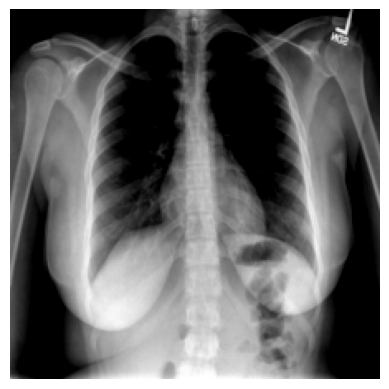



Actual Image and Text


Cardiomediastinal silhouette is within normal limits of size and appearance. The pulmonary vascularity is unremarkable. Lungs are expanded and clear of airspace disease. Negative for pneumothorax or pleural effusion. Limited bone evaluation reveals no acute abnormality. There is incompletely evaluated lumbar levoscoliosis.


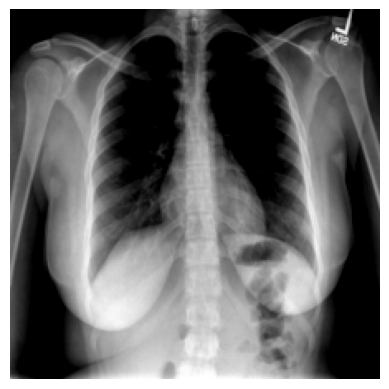

Prediction for index 41: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


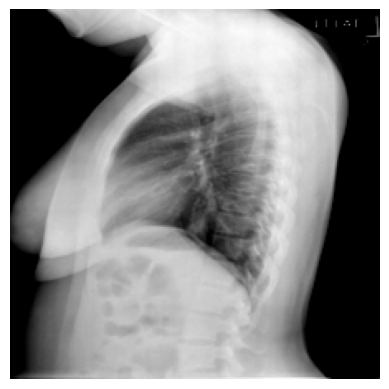



Actual Image and Text


Cardiomediastinal silhouette is within normal limits of size and appearance. The pulmonary vascularity is unremarkable. Lungs are expanded and clear of airspace disease. Negative for pneumothorax or pleural effusion. Limited bone evaluation reveals no acute abnormality. There is incompletely evaluated lumbar levoscoliosis.


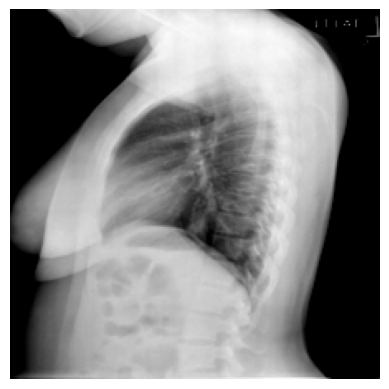

Prediction for index 42: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


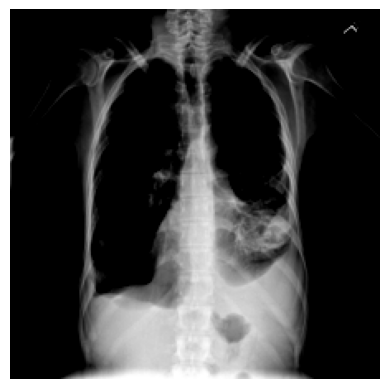



Actual Image and Text


The heart is within normal limits in size. Surgical suture material projects over the right lung apex. The lungs are hyperlucent and hyperinflated compatible with emphysema. There is left lower lobe airspace disease identified. There is moderate left pleural effusion and small right pleural effusion. No visualized pneumothorax.


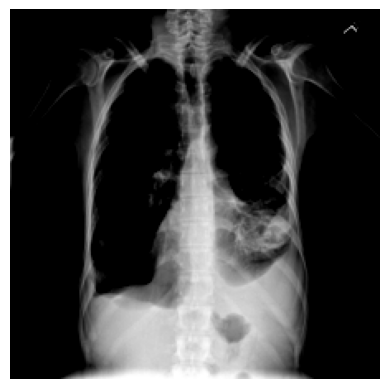

Prediction for index 43: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


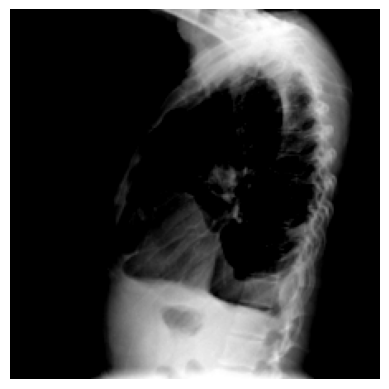



Actual Image and Text


The heart is within normal limits in size. Surgical suture material projects over the right lung apex. The lungs are hyperlucent and hyperinflated compatible with emphysema. There is left lower lobe airspace disease identified. There is moderate left pleural effusion and small right pleural effusion. No visualized pneumothorax.


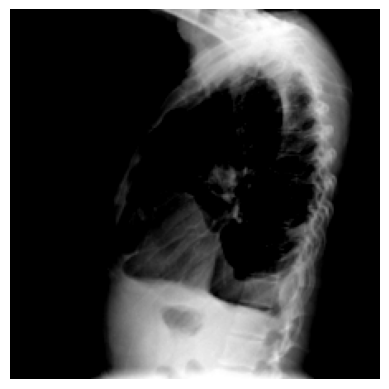

Prediction for index 44: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


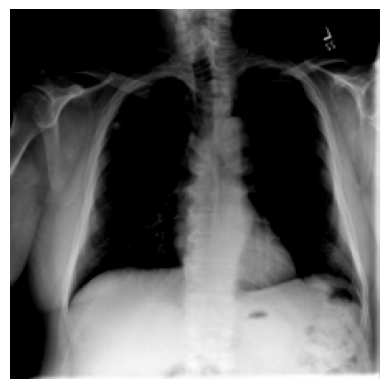



Actual Image and Text


The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.


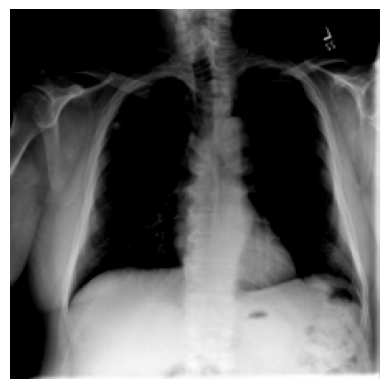

Prediction for index 45: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


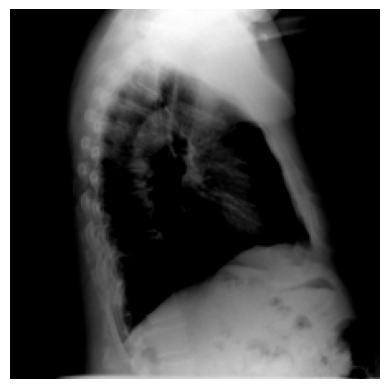



Actual Image and Text


The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.


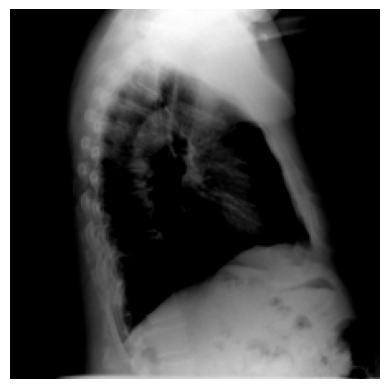

Prediction for index 46: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


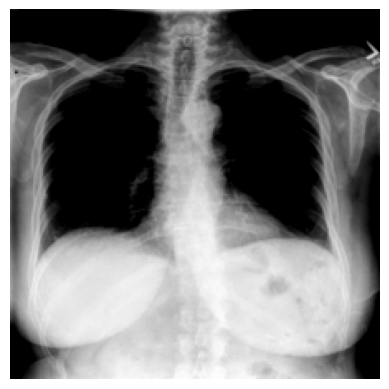



Actual Image and Text


Lungs are overall hyperexpanded with flattening of the diaphragms. No focal consolidation. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the thoracic spine.


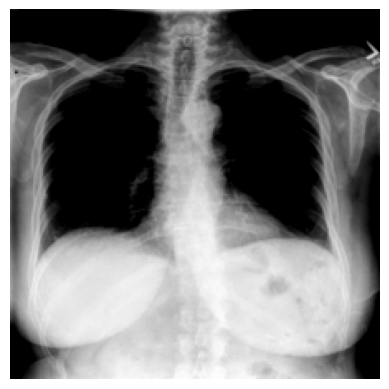

Prediction for index 47: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


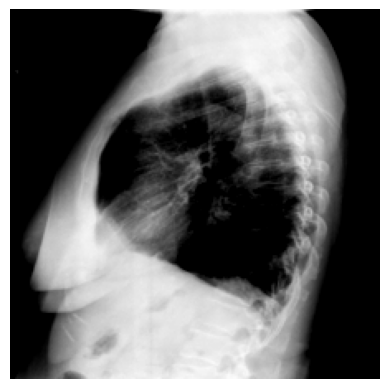



Actual Image and Text


Lungs are overall hyperexpanded with flattening of the diaphragms. No focal consolidation. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the thoracic spine.


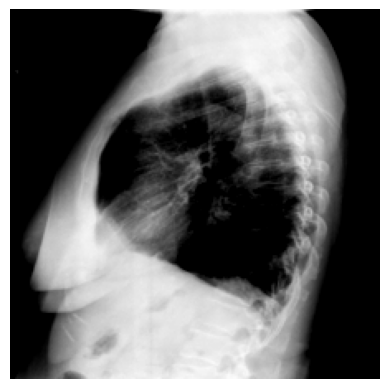

Prediction for index 48: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


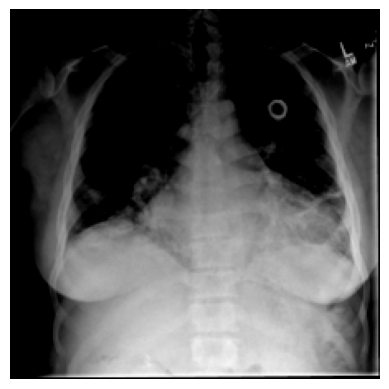



Actual Image and Text


Bilateral patchy pulmonary opacities noted. Interval improvement in left base consolidative opacity. Pulmonary vascular congestion again noted. Stable enlarged cardiomediastinal silhouette. Stable left XXXX. No evidence of pneumothorax. No large pleural effusions.


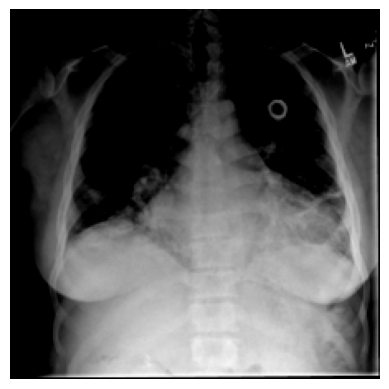

Prediction for index 49: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


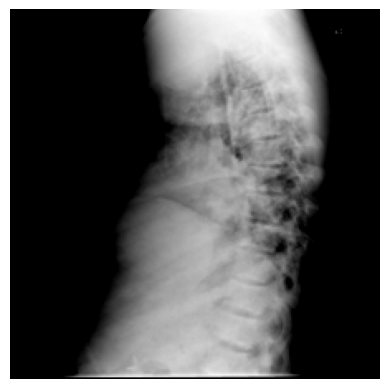



Actual Image and Text


Bilateral patchy pulmonary opacities noted. Interval improvement in left base consolidative opacity. Pulmonary vascular congestion again noted. Stable enlarged cardiomediastinal silhouette. Stable left XXXX. No evidence of pneumothorax. No large pleural effusions.


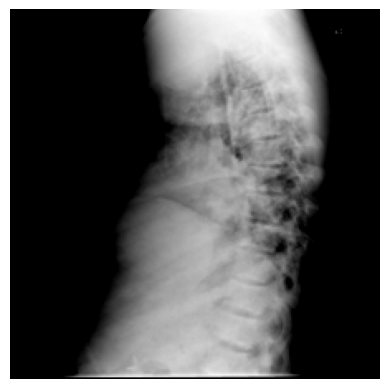

In [35]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a loop 
for idx in range(40, 50):
    inputs = val_ds[idx]['pixel_values']
    with torch.no_grad():
        # Model prediction 
        out = loaded_mode.generate(
            inputs.unsqueeze(0).to('cuda'),  # Move inputs to GPU
            num_beams=4,
            max_length=512
        )

    # Convert token ids to string format
    decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

    # Display the result
    print(f"Prediction for index {idx}: {decoded_out}")

    # Display the image
    plt.figure()
    plt.axis('off')
    plt.imshow(torch.permute(inputs, (1, 2, 0)))
    plt.show()

    print("\n\nActual Image and Text\n\n")
    # Display the text
    labels_tensor = val_ds[idx]['labels']

    decoded_out = tokenizer.decode(labels_tensor, skip_special_tokens=True)

    print(decoded_out)

    # Display actual image
    inputs = val_ds[idx]['pixel_values']

    # Convert the PyTorch tensor to a NumPy array
    image_array = inputs.permute(1, 2, 0).numpy()
    # Display the image using matplotlib
    plt.figure()
    plt.axis('off')
    plt.imshow(image_array)
    plt.show()


### Compute the BLEU score

In [36]:
import tqdm 
predicted_captions = [] 
for i in tqdm.tqdm( val_df['imgs']):
    
    img =  Image.open(i).convert("RGB")
    caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0],skip_special_tokens=True)
    predicted_captions.append(caption)
print(len(predicted_captions))


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 583/583 [04:44<00:00,  2.05it/s]

583


In [37]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Assuming you have a list of predicted captions and a list of ground truth captions
generated_captions = predicted_captions
ground_truth_captions = val_df['captions'].values
# Convert the caption lists into the format expected by nltk
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in generated_captions]


# Define the smoothing function to use
smoothie = SmoothingFunction().method4

# Compute the BLEU score with smoothing
weights = (0.25, 0.25, 0.25, 0.25)  # equal weights for 1-4 gram BLEU scores
score = corpus_bleu(ground_truth_captions, predicted_captions,weights =weights)
print(f'The BELU Score Is: {score}')

The BELU Score Is: 0.6929735963458677


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Save Model in .h5 Foramt

In [83]:
import h5py
import os
from pathlib import Path

# Convert PyTorch model parameters to NumPy arrays
model_dict = {key: value.cpu().numpy() for key, value in model.state_dict().items()}

# Specify the directory path
file_path = 'loadedd_model.h5'


# Save the parameters using h5py
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)

print(f'Model parameters saved to: {file_path}')


Model parameters saved to: loadedd_model.h5


In [85]:
from IPython.display import FileLink

# Specify the file path in the Kaggle environment
kaggle_file_path = '/kaggle/working/loadedd_model.h5'

# Create a downloadable link
FileLink(kaggle_file_path)


/kaggle/working/loadedd_model.h5

# This is the link of the model pushed to the hugging face: https://huggingface.co/Molkaatb/ChestX